In [1]:
from pyspark.sql.types import StructField,StructType,IntegerType,StringType,DateType,BooleanType,TimestampType,DecimalType,DoubleType
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import SparkSession

In [2]:
# create spark session
spark=SparkSession.builder.appName("T20 World Cups Analysis").getOrCreate()

In [3]:
#s3://ipl-analysis-till-2017/season.csv
season_schema = StructType([
    StructField("season_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("year", StringType(), True),
    StructField("description", StringType(), True),
    StructField("season", StringType(), True),
    StructField("startDate", DateType(), True),
    StructField("endDate", DateType(), True),
    StructField("totalSquads", IntegerType(), True)
])
season_df = spark.read.schema(season_schema).format("csv")\
    .option("header", "true")\
    .load("season.csv") 
season_df=season_df.dropDuplicates()
season_df.show()

+---------+--------------------+-------+--------------------+-------+----------+----------+-----------+
|season_id|                name|   year|         description| season| startDate|   endDate|totalSquads|
+---------+--------------------+-------+--------------------+-------+----------+----------+-----------+
|     4162|  ICC World Twenty20|   2009|          in England|   2009|2009-06-05|2009-06-21|         12|
|    14450|ICC Men's T20 Wor...|2022/23|        in Australia|2022/23|2022-10-16|2022-11-13|         16|
|     6856|  ICC World Twenty20|2012/13|        in Sri Lanka|2012/13|2012-09-18|2012-10-07|         12|
|    15946|ICC Men's T20 Wor...|   2024|in United States ...|   2024|2024-06-04|2024-06-30|         15|
|    14024|ICC Men's T20 Wor...|2021/22|in Oman/United Ar...|2021/22|2021-10-17|2021-11-14|         16|
|    10291|           World T20|2015/16|            in India|2015/16|2016-03-08|2016-04-03|         16|
|     8083|           World T20|2013/14|       in Bangladesh|201

In [4]:
#s3://icc-world-cup-analysis/team.csv
teams_schema = StructType([
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True),
    StructField("team_abbrevaion", StringType(), True),
    StructField("image", StringType(), True),
    StructField("country_id", IntegerType(), True)
])
teams_df = spark.read.schema(teams_schema).format("csv")\
    .option("header", "true")\
    .load("team.csv")
teams_df.show(1)

+-------+---------+---------------+--------------------+----------+
|team_id|team_name|team_abbrevaion|               image|country_id|
+-------+---------+---------------+--------------------+----------+
|      1|  England|            ENG|/db/PICTURES/CMS/...|         1|
+-------+---------+---------------+--------------------+----------+
only showing top 1 row



In [5]:
#s3://icc-world-cup-analysis/matches.csv
matches_schema = StructType([
    StructField("season_id", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("slug", StringType(), True),
    StructField("title", StringType(), True),
    StructField("time_of_day", StringType(), True),  # Using StringType for "time_of_day"
    StructField("date", DateType(), True),
    StructField("time", TimestampType(), True),  # Using TimestampType for time
    StructField("status", StringType(), True),
    StructField("status_description", StringType(), True),
    StructField("winner_team_id", IntegerType(), True),
    StructField("toss_winner_team_id", IntegerType(), True),
    StructField("toss_choice", IntegerType(), True),
    StructField("ground_id", IntegerType(), True),
    StructField("team_1_id", IntegerType(), True),
    StructField("team_2_id", IntegerType(), True),
    StructField("team_1_score", StringType(), True),
    StructField("team_1_scoreInfo", StringType(), True),
    StructField("team_2_scoreInfo", StringType(), True)
])

matches_df = spark.read.schema(matches_schema).format("csv")\
    .option("header", "true")\
    .load("matches.csv")
matches_df.show(2)

+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+
|season_id|match_id|                slug|             title|time_of_day|      date|               time|status|  status_description|winner_team_id|toss_winner_team_id|toss_choice|ground_id|team_1_id|team_2_id|team_1_score|team_1_scoreInfo|team_2_scoreInfo|
+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+
|     4162|   18581|england-vs-nether...|1st Match, Group B|   daynight|2009-06-05|2024-08-24 22:00:00|RESULT|Netherlands won b...|            15|                 15|          2|       10|        1|       15|       163/6|           

In [6]:
#s3://icc-world-cup-analysis/Grounds.csv
grounds_schema = StructType([
    StructField("Ground_ID", IntegerType(), True),
    StructField("Ground_Name", StringType(), True),
    StructField("Ground_Slug", StringType(), True),
    StructField("Town_ID", IntegerType(), True),
    StructField("Capacity", StringType(), True)  # Using StringType for "Capacity" as provided
])

grounds_df = spark.read.schema(grounds_schema).format("csv")\
    .option("header", "true")\
    .load("ground.csv")
grounds_df.show(2)

+---------+--------------------+--------------------+-------+--------+
|Ground_ID|         Ground_Name|         Ground_Slug|Town_ID|Capacity|
+---------+--------------------+--------------------+-------+--------+
|       10|      Lord's, London|       lord-s-london|    224|   30000|
|       45|Kennington Oval, ...|kennington-oval-l...|    224|   23500|
+---------+--------------------+--------------------+-------+--------+
only showing top 2 rows



In [7]:
#s3://icc-world-cup-analysis/Ball_By_Balls.csv
ball_by_balls_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("inningNumber", IntegerType(), True),
    StructField("overNumber", IntegerType(), True),
    StructField("ballNumber", IntegerType(), True),
    StructField("oversUnique", DecimalType(4,2), True),
    StructField("oversActual", DecimalType(4,2), True),
    StructField("batsmanPlayerId", IntegerType(), True),
    StructField("bowlerPlayerId", IntegerType(), True),
    StructField("pitchLine", StringType(), True),
    StructField("pitchLength", StringType(), True),
    StructField("isFour", BooleanType(), True),
    StructField("isSix", BooleanType(), True),
    StructField("isWicket", BooleanType(), True),
    StructField("byes", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalties", IntegerType(), True),
    StructField("run", IntegerType(), True),
    StructField("batsmanRuns", IntegerType(), True),
    StructField("totalRuns", IntegerType(), True),
    StructField("totalWickets", IntegerType(), True),
    StructField("outPlayerId", IntegerType(), True),
    StructField("shotType", StringType(), True)
])

ball_by_balls_df = spark.read.schema(ball_by_balls_schema).format("csv")\
    .option("header", "true")\
    .load("BallByBall.csv")
ball_by_balls_df.show(1)
#ball_by_balls_df.select("ballNumber","overNumber","run","batsmanRuns","totalRuns","totalWickets").show()

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+-------------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|    pitchLine|pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|shotType|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+-------------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------+
|    0|  100706|           1|         1|         1|       0.01|       0.10|          52584|         87127|ON_THE_STUMPS|GOOD_LENGTH| false|false|   false|   0|      0|    0|      0|        0|  0|          0|        0|           0|       NULL|DE

In [8]:
#s3://icc-world-cup-analysis/Countrys.csv
countrys_schema = StructType([
    StructField("Country_ID", IntegerType(), True),
    StructField("Country_Name", StringType(), True),
    StructField("Country_Abbreviation", StringType(), True)
])

countrys_df = spark.read.schema(countrys_schema).format("csv")\
    .option("header", "true")\
    .load("country.csv")
countrys_df.show(50)

+----------+--------------------+--------------------+
|Country_ID|        Country_Name|Country_Abbreviation|
+----------+--------------------+--------------------+
|         1|             England|                 ENG|
|         4|         West Indies|                  WI|
|         8|           Sri Lanka|                  SL|
|        25|          Bangladesh|                 BAN|
|         6|               India|                 IND|
|        37|                Oman|                 OMA|
|        27|United Arab Emirates|                 UAE|
|         2|           Australia|                 AUS|
|        11|United States of ...|                 USA|
+----------+--------------------+--------------------+



In [9]:
#s3://icc-world-cup-analysis/Towns.csv
towns_schema = StructType([
    StructField("Town_ID", IntegerType(), True),
    StructField("Town_Name", StringType(), True),
    StructField("Country_ID", IntegerType(), True)
])

towns_df = spark.read.schema(towns_schema).format("csv")\
    .option("header", "true")\
    .load("Town.csv")
towns_df.show(1)

+-------+---------+----------+
|Town_ID|Town_Name|Country_ID|
+-------+---------+----------+
|    224|   London|         1|
+-------+---------+----------+
only showing top 1 row



In [10]:
#s3://icc-world-cup-analysis/Players.csv

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

players_schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("Role", StringType(), True),
    StructField("Full Name", StringType(), True),
    StructField("Image", StringType(), True),
    StructField("DOB", StringType(), True),
    StructField("Batting Style (s)", StringType(), True),
    StructField("Bowling Style (s)", StringType(), True),
    StructField("Batting Style (l)", StringType(), True),
    StructField("Bowling Style(l)", StringType(), True),
    StructField("Team_ID", DoubleType(), True),  # Using DoubleType based on your provided data (2.0)
    StructField("Playing Role", StringType(), True)
])

players_df = spark.read.schema(players_schema).format("csv")\
    .option("header", "true")\
    .load("Players.csv")
players_df = players_df.withColumn("DOB", to_date(players_df["DOB"], "dd-MM-yyyy"))
players_df.show(1)

+----+----------+----+-------------+--------------------+----------+-----------------+-----------------+-----------------+----------------+-------+----------------+
|  ID|      Name|Role|    Full Name|               Image|       DOB|Batting Style (s)|Bowling Style (s)|Batting Style (l)|Bowling Style(l)|Team_ID|    Playing Role|
+----+----------+----+-------------+--------------------+----------+-----------------+-----------------+-----------------+----------------+-------+----------------+
|2230|RT Ponting|   C|Ricky Ponting|/db/PICTURES/CMS/...|1974-12-19|              rhb|               rm|   right-hand bat|right-arm medium|    2.0|top-order batter|
+----+----------+----+-------------+--------------------+----------+-----------------+-----------------+-----------------+----------------+-------+----------------+
only showing top 1 row



In [11]:
# possible transformations 

# Season.csv
# 1)Find the duration of particular season (in days)
season_df=season_df.withColumn('Season_Duration',datediff(col('endDate'),col('startDate')))
season_df.show(5)

+---------+--------------------+-------+--------------------+-------+----------+----------+-----------+---------------+
|season_id|                name|   year|         description| season| startDate|   endDate|totalSquads|Season_Duration|
+---------+--------------------+-------+--------------------+-------+----------+----------+-----------+---------------+
|     4162|  ICC World Twenty20|   2009|          in England|   2009|2009-06-05|2009-06-21|         12|             16|
|    14450|ICC Men's T20 Wor...|2022/23|        in Australia|2022/23|2022-10-16|2022-11-13|         16|             28|
|     6856|  ICC World Twenty20|2012/13|        in Sri Lanka|2012/13|2012-09-18|2012-10-07|         12|             19|
|    15946|ICC Men's T20 Wor...|   2024|in United States ...|   2024|2024-06-04|2024-06-30|         15|             26|
|    14024|ICC Men's T20 Wor...|2021/22|in Oman/United Ar...|2021/22|2021-10-17|2021-11-14|         16|             28|
+---------+--------------------+-------+

In [12]:
# Players.csv

# 1)Fill the missing values in bowling style with 'Does not bowl'
players_df=players_df.na.fill({'Bowling Style (s)':'unknown','Bowling Style(l)':'unknown'})
#players_df.select('Bowling Style (s)', 'Bowling Style(l)','Team ID').show()

# 2)Which country is the player from
players_df=players_df.join(teams_df,players_df.Team_ID==teams_df.team_id,'inner').select(players_df['*'],teams_df['team_name'])
players_df.show(2)

+----+----------+----+--------------+--------------------+----------+-----------------+-----------------+-----------------+--------------------+-------+-------------------+---------+
|  ID|      Name|Role|     Full Name|               Image|       DOB|Batting Style (s)|Bowling Style (s)|Batting Style (l)|    Bowling Style(l)|Team_ID|       Playing Role|team_name|
+----+----------+----+--------------+--------------------+----------+-----------------+-----------------+-----------------+--------------------+-------+-------------------+---------+
|2230|RT Ponting|   C| Ricky Ponting|/db/PICTURES/CMS/...|1974-12-19|              rhb|               rm|   right-hand bat|    right-arm medium|    2.0|   top-order batter|Australia|
|8876| MJ Clarke|  VC|Michael Clarke|/db/PICTURES/CMS/...|1981-04-02|              rhb|              sla|   right-hand bat|slow left-arm ort...|    2.0|middle-order batter|Australia|
+----+----------+----+--------------+--------------------+----------+----------------

In [13]:
#matches.csv

# 1)Find the season of each match being played
matches_df=matches_df.join(season_df,matches_df.season_id==season_df.season_id,'inner').select(matches_df['*'],season_df['season'])
matches_df.show(2)

+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+
|season_id|match_id|                slug|             title|time_of_day|      date|               time|status|  status_description|winner_team_id|toss_winner_team_id|toss_choice|ground_id|team_1_id|team_2_id|team_1_score|team_1_scoreInfo|team_2_scoreInfo|season|
+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+
|     4162|   18581|england-vs-nether...|1st Match, Group B|   daynight|2009-06-05|2024-08-24 22:00:00|RESULT|Netherlands won b...|            15|                 15|          2|       10|        1|       15|   

In [14]:
# 2)Impact of toss on match outcome
matches_df=matches_df.withColumn(
    'toss_match_winner',
    when(col('winner_team_id')==col('toss_winner_team_id'),'Yes').otherwise('No')
)
matches_df.show(2)

+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+-----------------+
|season_id|match_id|                slug|             title|time_of_day|      date|               time|status|  status_description|winner_team_id|toss_winner_team_id|toss_choice|ground_id|team_1_id|team_2_id|team_1_score|team_1_scoreInfo|team_2_scoreInfo|season|toss_match_winner|
+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+-----------------+
|     4162|   18581|england-vs-nether...|1st Match, Group B|   daynight|2009-06-05|2024-08-24 22:00:00|RESULT|Netherlands won b...|            15|           

In [15]:
# 3)Categorise win margins into high medium or low
matches_df=matches_df.withColumn("win_type",
                                when(col("status_description").contains("wickets"),"wickets")
                                 .when(col("status_description").contains("runs"),"runs")
)
matches_df=matches_df.withColumn("win_margin",
                                when(col("win_type")=="wickets",regexp_extract(col("status_description"),r"(\d+) wickets",1).cast("int"))
                                 .when(col("win_type")=="runs",regexp_extract(col("status_description"),r"(\d+) runs",1).cast("int"))
)
matches_df=matches_df.withColumn("win_category",
                                when((col("win_type")=="wickets") & (col("win_margin")>=7),"High")
                                 .when((col("win_type")=="wickets") & (col("win_margin")>=4) & (col("win_margin")<7),"Medium")
                                 .when((col("win_type")=="wickets") & (col("win_margin")<4),"Low")
                                 .when((col("win_type")=="runs") & (col("win_margin")>=70),"High")
                                 .when((col("win_type")=="runs") & (col("win_margin")>=30) & (col("win_margin")<70),"Medium")
                                 .when((col("win_type")=="runs") & (col("win_margin")<30),"Low")
)
matches_df.show(2)

+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+-----------------+--------+----------+------------+
|season_id|match_id|                slug|             title|time_of_day|      date|               time|status|  status_description|winner_team_id|toss_winner_team_id|toss_choice|ground_id|team_1_id|team_2_id|team_1_score|team_1_scoreInfo|team_2_scoreInfo|season|toss_match_winner|win_type|win_margin|win_category|
+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+-----------------+--------+----------+------------+
|     4162|   18581|england-vs-nether...|1st Match, Group 

In [16]:
# 4)Which ground the match is being played  
matches_df=matches_df.join(grounds_df,matches_df.ground_id==grounds_df.Ground_ID,'inner').select(matches_df['*'],grounds_df['ground_name'])
matches_df.show(2)

+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+-----------------+--------+----------+------------+--------------------+
|season_id|match_id|                slug|             title|time_of_day|      date|               time|status|  status_description|winner_team_id|toss_winner_team_id|toss_choice|ground_id|team_1_id|team_2_id|team_1_score|team_1_scoreInfo|team_2_scoreInfo|season|toss_match_winner|win_type|win_margin|win_category|         ground_name|
+---------+--------+--------------------+------------------+-----------+----------+-------------------+------+--------------------+--------------+-------------------+-----------+---------+---------+---------+------------+----------------+----------------+------+-----------------+--------+----------+------------+-----------------

In [17]:
# ground.csv

# 1)Categorize the stadium size based on capacity
grounds_df=grounds_df.na.fill({"capacity":"unknown"})
grounds_df=grounds_df.withColumn("ground_type",
                                 when(col("capacity")>=30000,"High")
                                 .when((col("capacity")>=15000) & (col("capacity")<30000),"Medium")
                                 .otherwise("Low")
)
grounds_df.show(5)

+---------+--------------------+--------------------+-------+--------------------+-----------+
|Ground_ID|         Ground_Name|         Ground_Slug|Town_ID|            Capacity|ground_type|
+---------+--------------------+--------------------+-------+--------------------+-----------+
|       10|      Lord's, London|       lord-s-london|    224|               30000|       High|
|       45|Kennington Oval, ...|kennington-oval-l...|    224|               23500|     Medium|
|       34|Trent Bridge, Not...|trent-bridge-nott...|    254|15,350 (to be 17,...|        Low|
|     1986|Providence Stadiu...|providence-stadiu...|   1076|              15,000|        Low|
|     1697|Beausejour Stadiu...|daren-sammy-natio...|   1019|              12,400|        Low|
+---------+--------------------+--------------------+-------+--------------------+-----------+
only showing top 5 rows



In [18]:
# 2)Which country has particular ground
grounds_df=grounds_df.join(towns_df,grounds_df.Town_ID==towns_df.Town_ID,'inner').join(countrys_df,towns_df.Country_ID==countrys_df.Country_ID,"inner").select(grounds_df['*'],countrys_df['Country_Name'])
grounds_df.show(2)

+---------+--------------------+--------------------+-------+--------+-----------+------------+
|Ground_ID|         Ground_Name|         Ground_Slug|Town_ID|Capacity|ground_type|Country_Name|
+---------+--------------------+--------------------+-------+--------+-----------+------------+
|       10|      Lord's, London|       lord-s-london|    224|   30000|       High|     England|
|       45|Kennington Oval, ...|kennington-oval-l...|    224|   23500|     Medium|     England|
+---------+--------------------+--------------------+-------+--------+-----------+------------+
only showing top 2 rows



In [19]:
# ballbyball.csv

# 1)If the delivery is a legal deilvery or an extra
ball_by_balls_df=ball_by_balls_df.withColumn(
    "is_extra",when((col("byes")>0) | (col("legbyes")>0) | (col("wides")>0) | (col("noballs")>0),"Yes").otherwise("No")
)
ball_by_balls_df.show(2)

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+-------------+--------------------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------+--------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|    pitchLine|         pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|shotType|is_extra|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+-------------+--------------------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------+--------+
|    0|  100706|           1|         1|         1|       0.01|       0.10|          52584|         87127|ON_THE_STUMPS|         GOOD_LENGTH| false|false|   false|   0|      0|    0|      0|

In [20]:
# 2)If the phase of the match is powerplay, middle overs or death
ball_by_balls_df=ball_by_balls_df.withColumn(
    "match_phase",
    when((col("overNumber")>=1) & (col("overNumber")<=6),"Powerplay")
    .when((col("overNumber")>=7) & (col("overNumber")<=15),"Middle Overs")
    .otherwise("Death Overs")
)
ball_by_balls_df.show(5)

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+-------------+--------------------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+-----------+--------+-----------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|    pitchLine|         pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|   shotType|is_extra|match_phase|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+-------------+--------------------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+-----------+--------+-----------+
|    0|  100706|           1|         1|         1|       0.01|       0.10|          52584|         87127|ON_THE_STUMPS|         GOOD_LENGTH| fal

In [21]:
# 3)runs scored in each over of each innings in a match
window_spec=Window.partitionBy("overNumber","inningNumber","match_id").orderBy("ballNumber")
ball_by_balls_df=ball_by_balls_df.withColumn(
    "over_by_over_score",
    sum("run").over(window_spec)
)
ball_by_balls_df.show(1)
#ball_by_balls_df.select("inningNumber","overNumber","run").orderBy(col("match_id").asc(),col("inningNumber").asc(),col("overNumber").asc()).show(12)

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|pitchLine|pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|            shotType|is_extra|match_phase|over_by_over_score|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+
|20036|   18581|           1|         1|         1|       0.01|       0.10|          44691|         

In [22]:
# 4)Dot ball indicator
ball_by_balls_df=ball_by_balls_df.withColumn(
    "is_dot_ball",
    when(col("run")==0,"Yes").otherwise("No")
)
ball_by_balls_df.show(5)

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+-----------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|pitchLine|pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|            shotType|is_extra|match_phase|over_by_over_score|is_dot_ball|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+-----------+
|20036|   18581|           1|         1|         1|       0.01| 

In [23]:
# 5)Boundary indicator
ball_by_balls_df=ball_by_balls_df.withColumn(
    "is_boundary",
    when((col("isFour")==True) | (col("isSix")==True),"Yes").otherwise("No")
)
ball_by_balls_df.show(5)

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+-----------+-----------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|pitchLine|pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|            shotType|is_extra|match_phase|over_by_over_score|is_dot_ball|is_boundary|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+-----------+-----------+
|20036|   18581|           1

In [24]:
# 6)Over outcome
ball_by_balls_df=ball_by_balls_df.withColumn(
    "over_outcome",
    when(col("over_by_over_score")==0,"Maiden")
    .when(col("over_by_over_score")>9,"Expensive")
    .otherwise("Normal")
)
ball_by_balls_df.show(5)

+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+-----------+-----------+------------+
|index|match_id|inningNumber|overNumber|ballNumber|oversUnique|oversActual|batsmanPlayerId|bowlerPlayerId|pitchLine|pitchLength|isFour|isSix|isWicket|byes|legbyes|wides|noballs|penalties|run|batsmanRuns|totalRuns|totalWickets|outPlayerId|            shotType|is_extra|match_phase|over_by_over_score|is_dot_ball|is_boundary|over_outcome|
+-----+--------+------------+----------+----------+-----------+-----------+---------------+--------------+---------+-----------+------+-----+--------+----+-------+-----+-------+---------+---+-----------+---------+------------+-----------+--------------------+--------+-----------+------------------+-----------+-----------+---

In [25]:
towns_df.createOrReplaceTempView("town")
teams_df.createOrReplaceTempView("teams")
season_df.createOrReplaceTempView("season")
players_df.createOrReplaceTempView("players")
matches_df.createOrReplaceTempView("matches")
grounds_df.createOrReplaceTempView("grounds")
countrys_df.createOrReplaceTempView("countrys")
ball_by_balls_df.createOrReplaceTempView("ballbyball")

In [26]:
spark.sql("""
select * from town
""").show()

spark.sql("""
select * from teams
""").show()

spark.sql("""
select * from season
""").show()

spark.sql("""
select * from players
""").show()

spark.sql("""
select * from matches
""").show()

spark.sql("""
select * from grounds
""").show()

spark.sql("""
select * from countrys
""").show()

spark.sql("""
select * from ballbyball
""").show()

+-------+----------+----------+
|Town_ID| Town_Name|Country_ID|
+-------+----------+----------+
|    224|    London|         1|
|    254|Nottingham|         1|
|   1076|Providence|         4|
|   1019|Gros Islet|         4|
|    988|Bridgetown|         4|
|   1251|Hambantota|         8|
|    955|   Colombo|         8|
|    958|     Kandy|         8|
|     58|     Dhaka|        25|
|     57|Chattogram|        25|
|     68|    Sylhet|        25|
|    670|    Nagpur|         6|
|    586|Dharamsala|         6|
|    574|   Kolkata|         6|
|    665|    Mumbai|         6|
|    549| Bengaluru|         6|
|   1684|    Mohali|         6|
|    584|     Delhi|         6|
|   1576| Al Amarat|        37|
|    977| Abu Dhabi|        27|
+-------+----------+----------+
only showing top 20 rows

+-------+------------+---------------+--------------------+----------+
|team_id|   team_name|team_abbrevaion|               image|country_id|
+-------+------------+---------------+--------------------+-----

In [61]:
# Possible Insights

# 1)Number of grounds in each country
grounds_per_country=spark.sql("""
select c.Country_Abbreviation as country,count(g.Ground_Name) as ground_cnt
from grounds g
inner join town t
on g.Town_ID=t.Town_ID
inner join countrys c
on t.Country_ID=c.Country_ID
group by c.Country_Abbreviation
order by count(g.Ground_Name) desc
""")
grounds_per_country.show(100)

+-------+----------+
|country|ground_cnt|
+-------+----------+
|    AUS|         7|
|    IND|         7|
|     WI|         6|
|     SL|         3|
|    ENG|         3|
|    BAN|         3|
|    USA|         3|
|    UAE|         3|
|    OMA|         1|
+-------+----------+



In [66]:
# 2)Longest season in terms of duration(days)

season_duration=spark.sql("""
select season,Season_Duration
from season
order by Season_Duration desc
limit 5
""")
season_duration.show()

+-------+---------------+
| season|Season_Duration|
+-------+---------------+
|2022/23|             28|
|2021/22|             28|
|   2024|             26|
|2015/16|             26|
|2013/14|             21|
+-------+---------------+



In [67]:
# 3)Season with most teams

squads_count=spark.sql("""
select season,totalSquads
from season
order by totalSquads desc
limit 5
""")
squads_count.show()

+-------+-----------+
| season|totalSquads|
+-------+-----------+
|2022/23|         16|
|2021/22|         16|
|2015/16|         16|
|2013/14|         16|
|   2024|         15|
+-------+-----------+



In [68]:
# 4)Teams with most wins

teams_with_most_wins=spark.sql("""
select min(t.team_name) as team,count(winner_team_id) as wins
from matches m
inner join teams t
on m.winner_team_id=t.team_id
where  winner_team_id is not null
group by winner_team_id
order by count(winner_team_id) desc
""")
teams_with_most_wins.show()

+------------+----+
|        team|wins|
+------------+----+
|   Sri Lanka|  28|
|     England|  23|
|       India|  23|
|    Pakistan|  23|
|   Australia|  22|
|South Africa|  20|
| New Zealand|  20|
| West Indies|  19|
| Netherlands|   9|
|  Bangladesh|   8|
|    Zimbabwe|   7|
|     Ireland|   7|
| Afghanistan|   7|
|    Scotland|   5|
|     Namibia|   4|
|       Nepal|   2|
|        Oman|   2|
|   Hong Kong|   1|
|      U.A.E.|   1|
+------------+----+



In [69]:
# 5)Top 10 biggest win margins by runs

biggest_wins_by_runs=spark.sql("""
select slug,win_margin
from matches
where win_type='runs'
order by win_margin desc
limit 10
""")
biggest_wins_by_runs.show()

+--------------------+----------+
|                slug|win_margin|
+--------------------+----------+
|scotland-vs-south...|       130|
|afghanistan-vs-sc...|       130|
|afghanistan-vs-en...|       116|
|bangladesh-vs-sou...|       104|
|england-vs-india-...|        90|
|australia-vs-new-...|        89|
|pakistan-vs-west-...|        84|
|bangladesh-vs-pap...|        84|
|ireland-vs-new-ze...|        83|
|sri-lanka-vs-zimb...|        82|
+--------------------+----------+



In [70]:
# 6)Highest matches in every season

most_matches_season=spark.sql("""
with cte1 as
(select distinct season_id,match_id
from matches)
,cte2 as(
select distinct season_id,season 
from season)
select min(cte2.season) as season,count(cte1.match_id) as no_of_matches
from cte1
inner join cte2
on cte1.season_id=cte2.season_id
group by cte1.season_id
order by count(cte1.match_id) desc
""")
most_matches_season.show(50)

+-------+-------------+
| season|no_of_matches|
+-------+-------------+
|   2024|           55|
|2021/22|           45|
|2022/23|           45|
|2013/14|           35|
|2015/16|           35|
|   2009|           27|
|   2010|           27|
|2012/13|           27|
+-------+-------------+



In [71]:
# 7)Average first innings score each season

avg_first_inn_score=spark.sql("""
with cte1 as(
select season_id,b.match_id,max(totalRuns) as match_score
from ballbyball b
inner join matches m
on b.match_id=m.match_id
where inningNumber=1
group by season_id,b.match_id
order by season_id,b.match_id)
select min(season) as season,floor(avg(match_score)) as avg_first_innings_score
from cte1
inner join season s
on cte1.season_id=s.season_id
group by cte1.season_id
""")
avg_first_inn_score.show(130)

+-------+-----------------------+
| season|avg_first_innings_score|
+-------+-----------------------+
|   2009|                    153|
|   2010|                    153|
|2012/13|                    153|
|2013/14|                    147|
|2015/16|                    152|
|2021/22|                    142|
|2022/23|                    152|
+-------+-----------------------+



In [72]:
# 8)Top 10 run getters in across all seasons

top_run_getters=spark.sql("""
select min(p.Name) as batsman,sum(batsmanRuns) as runs
from ballbyball b
inner join players p
on b.batsmanPlayerId=p.ID
group by b.batsmanPlayerId 
order by sum(batsmanRuns) desc
limit 10
""")
top_run_getters.show()

+----------------+----+
|         batsman|runs|
+----------------+----+
|         V Kohli|1141|
|       RG Sharma| 875|
|DPMD Jayawardene| 857|
|        CH Gayle| 848|
|      TM Dilshan| 832|
|       DA Warner| 806|
|      JC Buttler| 799|
|   KS Williamson| 699|
| Shakib Al Hasan| 675|
|  AB de Villiers| 667|
+----------------+----+



In [73]:
# 9) Top 10 wicket takers across all seasons

top_wkt_takers=spark.sql("""
select min(p.Name) as bowler,count(case when isWicket=True then 1 end) as wickets
from ballbyball b
inner join players p
on b.bowlerPlayerId=p.ID
group by b.bowlerPlayerId 
order by count(case when isWicket=True then 1 end) desc
limit 10
""")
top_wkt_takers.show()

+---------------+-------+
|         bowler|wickets|
+---------------+-------+
|Shakib Al Hasan|     45|
|     SL Malinga|     39|
|    Saeed Ajmal|     37|
|     BAW Mendis|     36|
|       R Ashwin|     33|
|       DW Steyn|     32|
|     TG Southee|     31|
|   PW Hasaranga|     31|
|       DJ Bravo|     30|
|  Shahid Afridi|     28|
+---------------+-------+



In [74]:
# 10)Compare wins of teams based on home and away matches

home_vs_away=spark.sql("""
select t.team_name,count(case when t.team_name=g.Country_Name then 1 end) as home_wins,count(case when t.team_name!=g.Country_Name then 1 end) as away_wins
from matches m
inner join grounds g
on m.ground_id=g.ground_id
inner join teams t
on m.winner_team_id=t.team_id
group by t.team_name
""")
home_vs_away.show(50)

+------------+---------+---------+
|   team_name|home_wins|away_wins|
+------------+---------+---------+
| Afghanistan|        0|        7|
|   Sri Lanka|        4|       24|
|       India|        3|       20|
| West Indies|        3|       16|
|  Bangladesh|        2|        6|
|     Ireland|        0|        7|
|   Hong Kong|        0|        1|
|      U.A.E.|        0|        1|
|        Oman|        1|        1|
|    Zimbabwe|        0|        7|
|     Namibia|        0|        4|
| New Zealand|        0|       20|
|     England|        2|       21|
|   Australia|        3|       19|
|       Nepal|        0|        2|
|South Africa|        0|       20|
|    Scotland|        0|        5|
|    Pakistan|        0|       23|
| Netherlands|        0|        9|
+------------+---------+---------+



In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
grounds_per_country=grounds_per_country.toPandas()
season_duration=season_duration.toPandas()
squads_count=squads_count.toPandas()
teams_with_most_wins=teams_with_most_wins.toPandas()
biggest_wins_by_runs=biggest_wins_by_runs.toPandas()
most_matches_season=most_matches_season.toPandas()
avg_first_inn_score=avg_first_inn_score.toPandas()
top_run_getters=top_run_getters.toPandas()
top_wkt_takers=top_wkt_takers.toPandas()
home_vs_away=home_vs_away.toPandas()

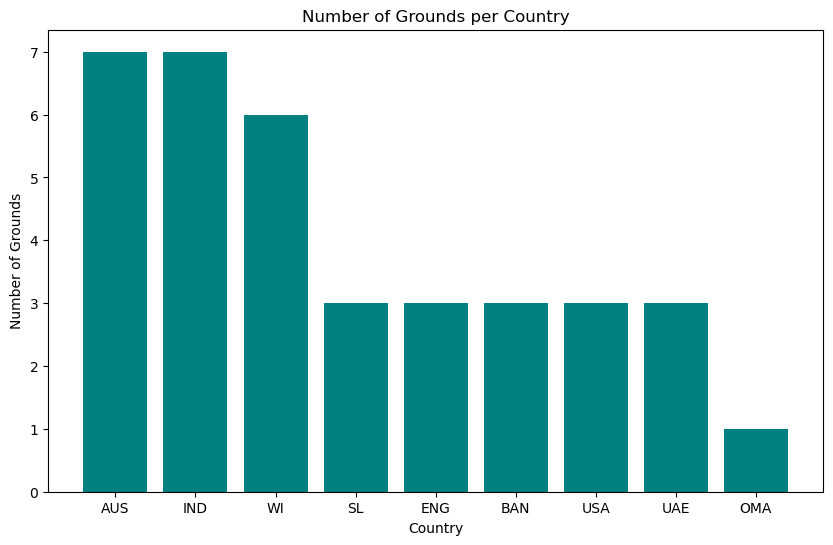

In [115]:
# Visualising the insights

# 1) Grounds per country
plt.figure(figsize=(10, 6))
plt.bar(grounds_per_country['country'], grounds_per_country['ground_cnt'], color='teal')
plt.title('Number of Grounds per Country')
plt.ylabel('Number of Grounds')
plt.xlabel('Country')
plt.show()


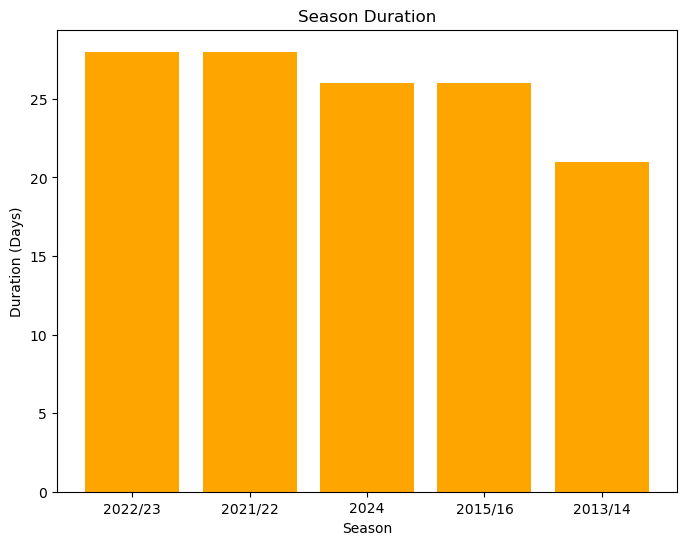

In [89]:
plt.figure(figsize=(8, 6))
plt.bar(season_duration['season'], season_duration['Season_Duration'], color='orange')
plt.title('Season Duration')
plt.xlabel('Season')
plt.ylabel('Duration (Days)')
plt.show()

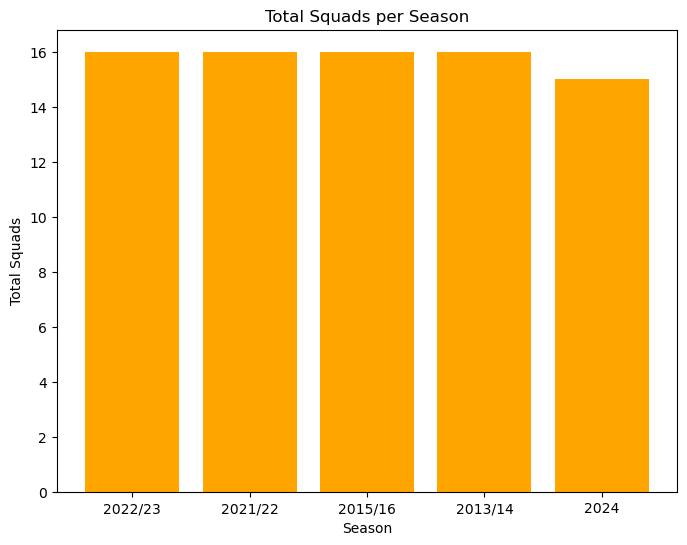

In [92]:
plt.figure(figsize=(8, 6))
plt.bar(squads_count['season'], squads_count['totalSquads'], color='orange')
plt.title('Total Squads per Season')
plt.xlabel('Season')
plt.ylabel('Total Squads')
plt.show()

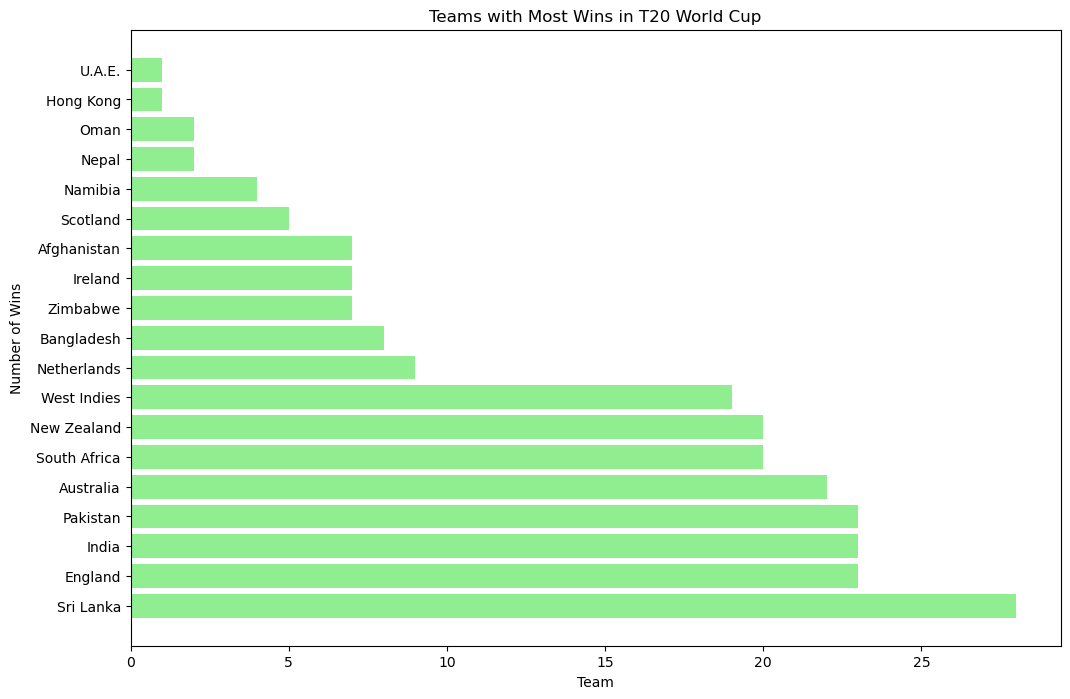

In [99]:
plt.figure(figsize=(12, 8))
plt.barh(teams_with_most_wins['team'], teams_with_most_wins['wins'], color='lightgreen')
plt.title('Teams with Most Wins in T20 World Cup')
plt.ylabel('Number of Wins')
plt.xlabel('Team')
plt.show()

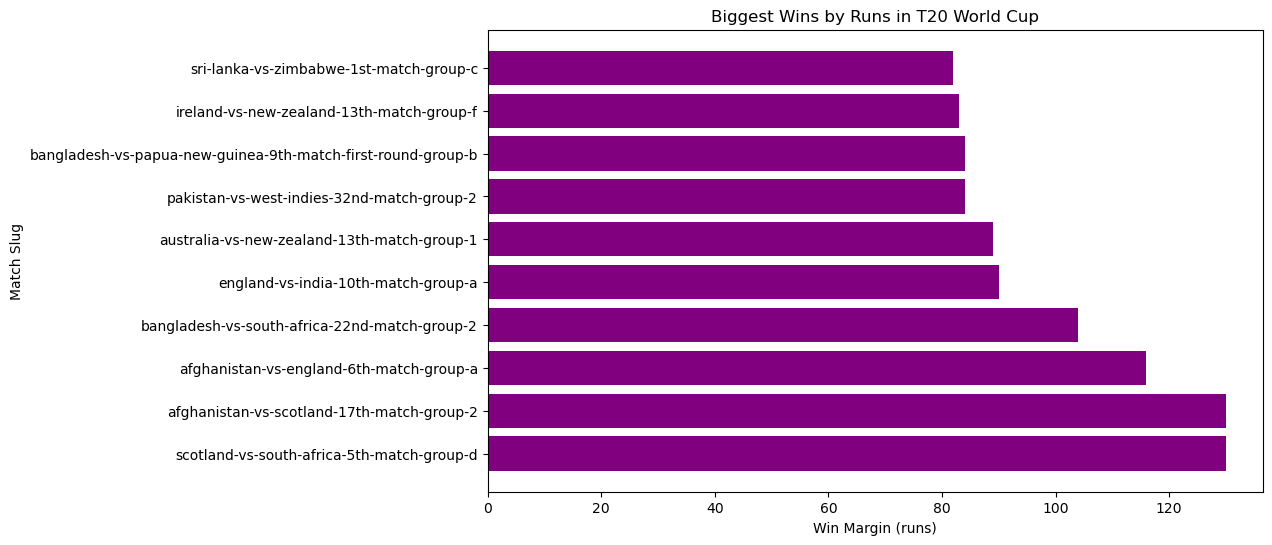

In [98]:
plt.figure(figsize=(10, 6))
plt.barh(biggest_wins_by_runs['slug'], biggest_wins_by_runs['win_margin'], color='purple')
plt.title('Biggest Wins by Runs in T20 World Cup')
plt.xlabel('Win Margin (runs)')
plt.ylabel('Match Slug')
plt.show()

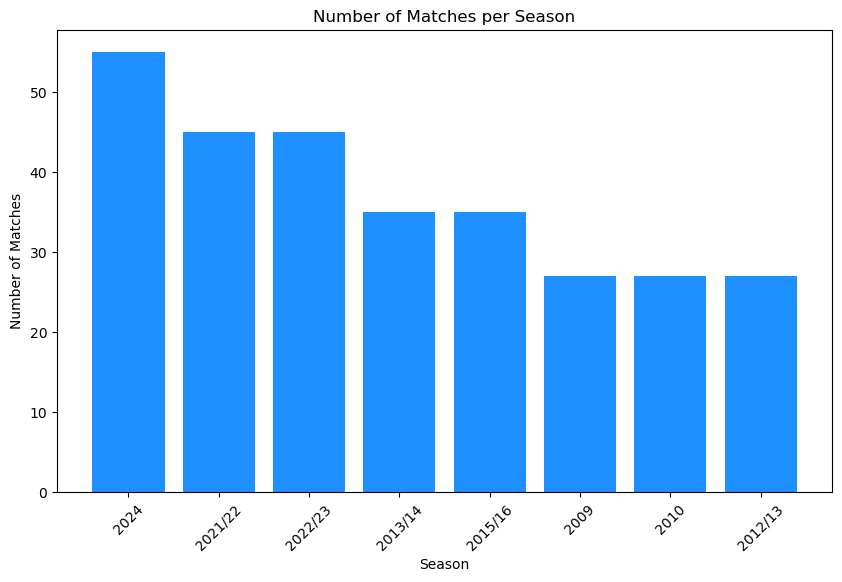

In [102]:
plt.figure(figsize=(10, 6))
plt.bar(most_matches_season['season'], most_matches_season['no_of_matches'], color='dodgerblue')
plt.title('Number of Matches per Season')
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.show()

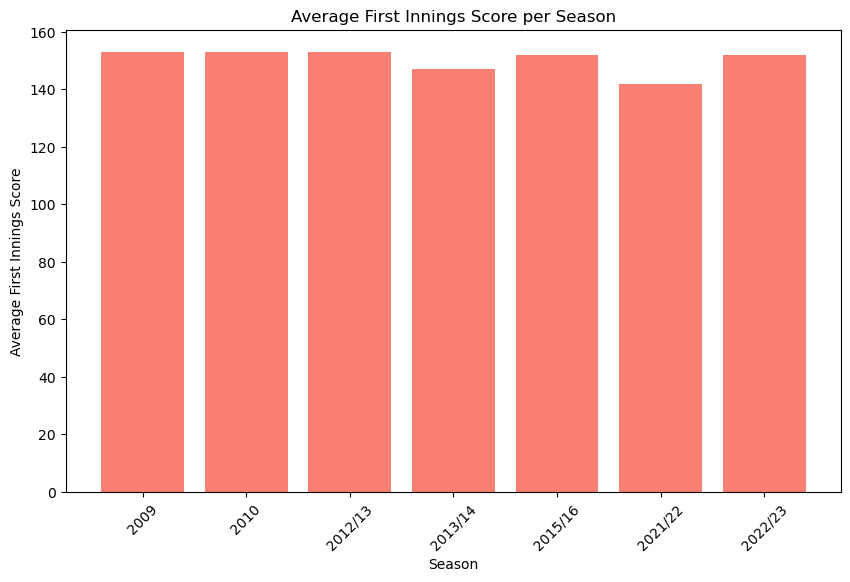

In [103]:
plt.figure(figsize=(10, 6))
plt.bar(avg_first_inn_score['season'], avg_first_inn_score['avg_first_innings_score'], color='salmon')
plt.title('Average First Innings Score per Season')
plt.xlabel('Season')
plt.ylabel('Average First Innings Score')
plt.xticks(rotation=45)
plt.show()

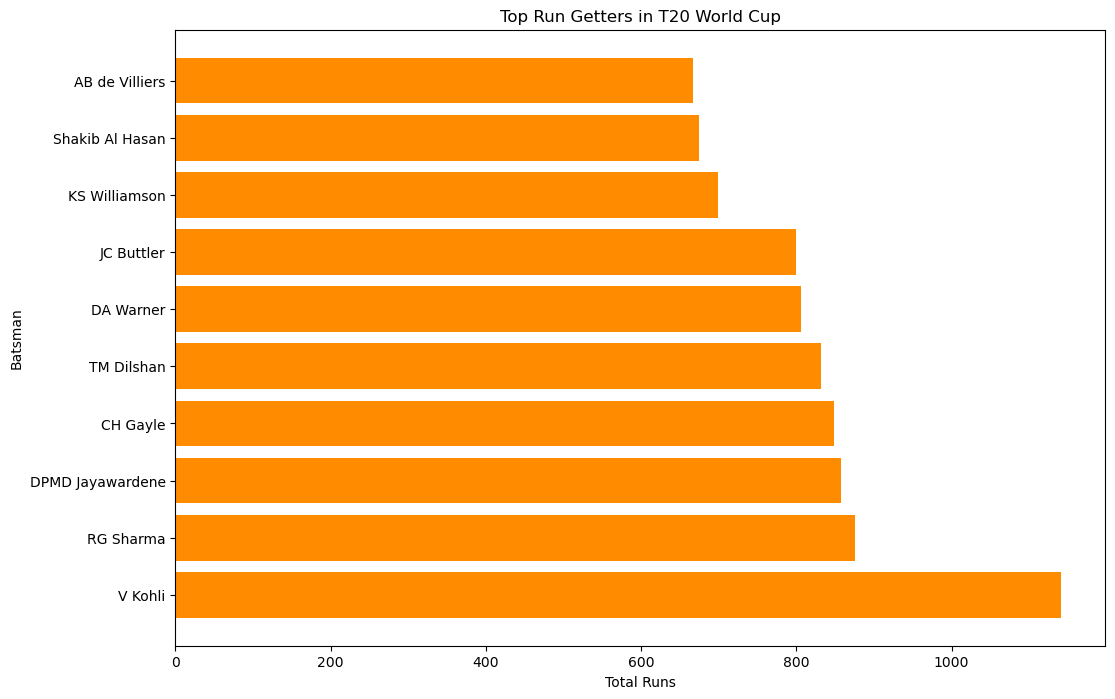

In [104]:
plt.figure(figsize=(12, 8))
plt.barh(top_run_getters['batsman'], top_run_getters['runs'], color='darkorange')
plt.title('Top Run Getters in T20 World Cup')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.show()

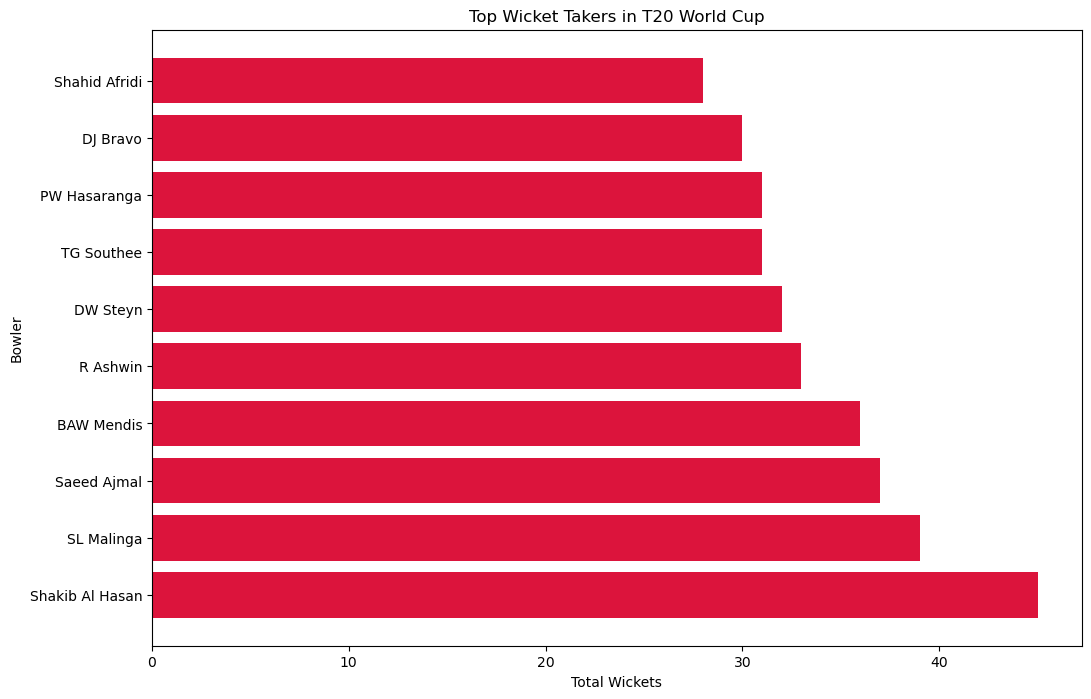

In [105]:
plt.figure(figsize=(12, 8))
plt.barh(top_wkt_takers['bowler'], top_wkt_takers['wickets'], color='crimson')
plt.title('Top Wicket Takers in T20 World Cup')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.show()

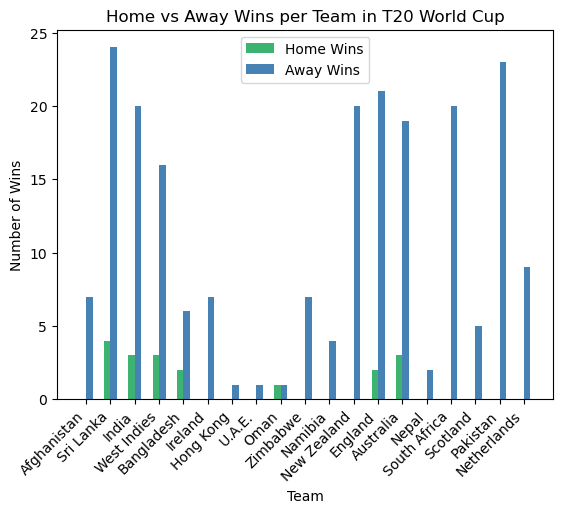

In [123]:
bar_width = 0.4
spacing_between_groups = 1.5 
x = [i * spacing_between_groups for i in range(len(home_vs_away['team_name']))]

# Plot the home wins
plt.bar([p - bar_width / 2 for p in x], home_vs_away['home_wins'], width=bar_width, label='Home Wins', color='mediumseagreen')

# Plot the away wins, offset by the bar width
plt.bar([p + bar_width / 2 for p in x], home_vs_away['away_wins'], width=bar_width, label='Away Wins', color='steelblue')

# Add title and labels
plt.title('Home vs Away Wins per Team in T20 World Cup')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.legend()
plt.xticks(x, home_vs_away['team_name'], rotation=45, ha='right')

plt.grid(False)